# Install Library

In [ ]:
!pip install facenet-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=e9262e05daad0e09cb191b6b7f35fab5f62f0aabbbab689776e30784c396c0c1
  Stored in directory: /root/.cache/pip/wheels/bc/52/78/893c3b94279ef238f43a9e89608af648de401b96415bebbd1f
Successfully built grad-cam


# Mempersiapkan dataset

## Data Sekunder dari Hugging Face

In [ ]:
from google.colab import drive
import os
import zipfile
import pandas as pd

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Path ke file ZIP di Google Drive
zip_path = '/content/drive/MyDrive/preprocessed.zip'

# 3. Ekstrak ZIP ke folder lokal
extract_path = '/content'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Mounted at /content/drive


### menampilkan isi dataset

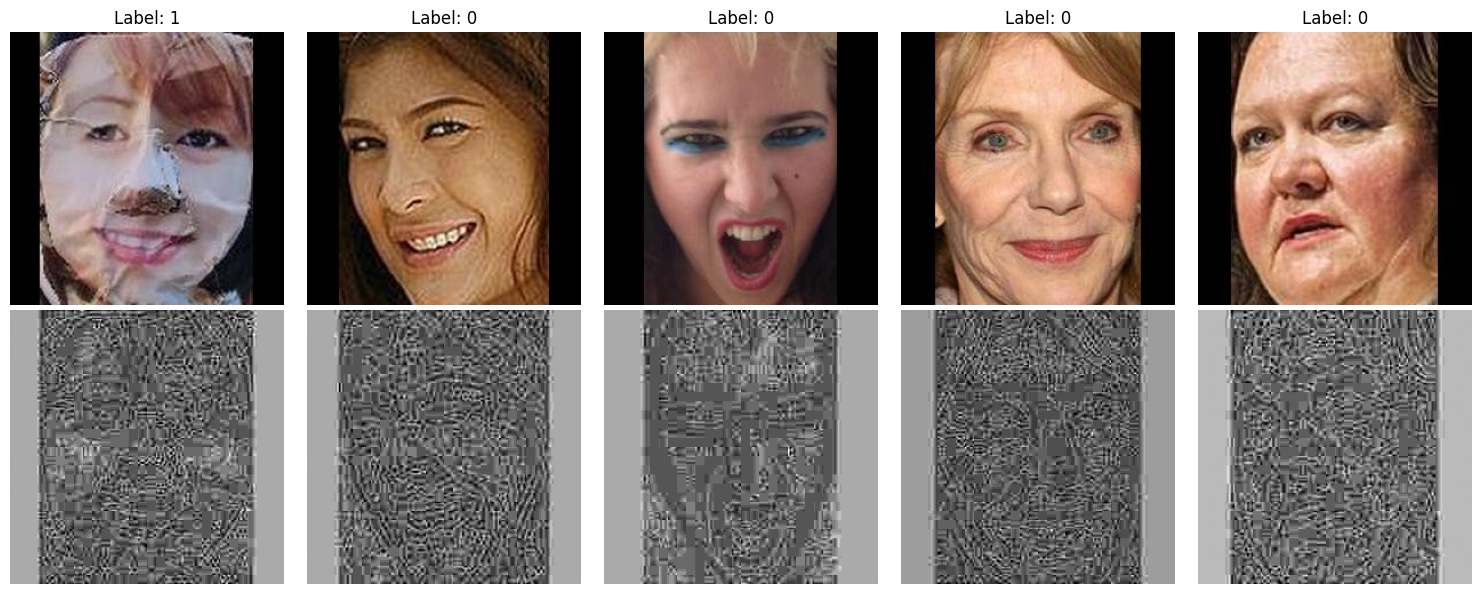

In [ ]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Load metadata hasil preprocessing
metadata_df = pd.read_csv('/content/preprocessed/metadata_1.csv')

# Tampilkan N contoh pertama
num_samples = 5
samples = metadata_df.sample(num_samples, random_state=42)

# Plot
fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
for i, row in enumerate(samples.itertuples()):
    # Buka gambar RGB dan LBP
    rgb_image = Image.open(row.rgb)
    lbp_image = Image.open(row.lbp)

    # Baris atas: RGB
    axes[0, i].imshow(rgb_image)
    axes[0, i].set_title(f"Label: {row.label}")
    axes[0, i].axis('off')

    # Baris bawah: LBP
    axes[1, i].imshow(lbp_image, cmap='gray')
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('RGB')
axes[1, 0].set_ylabel('LBP')
plt.tight_layout()
plt.show()


### membagi train, val, test

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# ====== Dataset Class ======
class SpoofDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        rgb_image = Image.open(row['rgb']).convert('RGB')
        lbp_image = Image.open(row['lbp']).convert('L')  # LBP adalah grayscale
        label = torch.tensor(row['label'], dtype=torch.long)

        if self.transform:
            rgb_image = self.transform(rgb_image)
            lbp_image = self.transform(lbp_image)

        return rgb_image, lbp_image, label

# ====== Balanced Manual Split ======
metadata_df = pd.read_csv('/content/preprocessed/metadata_1.csv')

live_df = metadata_df[metadata_df['label'] == 0].reset_index(drop=True)
spoof_df = metadata_df[metadata_df['label'] == 1].reset_index(drop=True)

def balanced_split(df, train_ratio=0.8, val_ratio=0.1):
    total = len(df)
    train_end = int(train_ratio * total)
    val_end = int((train_ratio + val_ratio) * total)
    train = df.iloc[:train_end]
    val = df.iloc[train_end:val_end]
    test = df.iloc[val_end:]
    return train, val, test

live_train, live_val, live_test = balanced_split(live_df)
spoof_train, spoof_val, spoof_test = balanced_split(spoof_df)

train_df = pd.concat([live_train, spoof_train]).sample(frac=1, random_state=42).reset_index(drop=True)
val_df = pd.concat([live_val, spoof_val]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([live_test, spoof_test]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Train:", train_df['label'].value_counts().to_dict())
print("Val:", val_df['label'].value_counts().to_dict())
print("Test:", test_df['label'].value_counts().to_dict())

# ====== Transforms and DataLoaders ======
# ====== Transforms and DataLoaders ======
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(size=(240, 240), scale=(0.8, 1.0)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.ToTensor()
])

batch_size = 64
train_dataset = SpoofDataset(train_df, transform=train_transform)
val_dataset = SpoofDataset(val_df, transform=test_transform)
test_dataset = SpoofDataset(test_df, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train: {0: 4000, 1: 4000}
Val: {1: 500, 0: 500}
Test: {1: 500, 0: 500}


### Menentukan jumlah sample yang dipakai

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np
import torch
from torch.utils.data import Subset, DataLoader

# === Fungsi Hitung Cohen’s d ===
def cohen_d(x, y):
    nx, ny = len(x), len(y)
    pooled_std = np.sqrt(((nx - 1)*np.var(x, ddof=1) + (ny - 1)*np.var(y, ddof=1)) / (nx + ny - 2))
    return (np.mean(x) - np.mean(y)) / pooled_std if pooled_std > 0 else 0.0

def effect_size_average(X_live, X_spoof):
    return np.mean([abs(cohen_d(X_live[:, i], X_spoof[:, i])) for i in range(X_live.shape[1])])

# === Evaluasi Akurasi ===
def evaluate_model(model, dataloader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for rgb, lbp, label in dataloader:
            rgb, lbp = rgb.to(device), lbp.to(device)
            outputs = model(rgb, lbp)
            pred = torch.argmax(outputs, dim=1).cpu().numpy()
            y_pred.extend(pred)
            y_true.extend(label.numpy())
    return accuracy_score(y_true, y_pred)

# === Ekstraksi Fitur
def extract_embeddings(model, dataloader, device):
    model.eval()
    embeddings, labels = [], []
    with torch.no_grad():
        for rgb, lbp, label in dataloader:
            rgb, lbp = rgb.to(device), lbp.to(device)
            feats = model.extract_features(rgb, lbp)
            embeddings.append(feats.cpu().numpy())
            labels.extend(label.numpy())
    return np.vstack(embeddings), np.array(labels)

# === K-Fold Training dan Evaluasi
def run_10fold_cv(dataset, model_class, device, batch_size=64, num_epochs=10):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    labels = [label for _, _, label in dataset]
    accs, ds = [], []

    for fold, (train_idx, test_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
        print(f"\n🔁 Fold {fold+1}/10")

        train_set = Subset(dataset, train_idx)
        test_set = Subset(dataset, test_idx)
        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

        model = model_class().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        criterion = torch.nn.CrossEntropyLoss()

        for epoch in range(num_epochs):
            model.train()
            for rgb, lbp, label in train_loader:
                rgb, lbp, label = rgb.to(device), lbp.to(device), label.to(device)
                optimizer.zero_grad()
                output = model(rgb, lbp)
                loss = criterion(output, label)
                loss.backward()
                optimizer.step()

        acc = evaluate_model(model, test_loader, device)
        feats, lbls = extract_embeddings(model, test_loader, device)
        X_live = feats[lbls == 0]
        X_spoof = feats[lbls == 1]
        d = effect_size_average(X_live, X_spoof)

        print(f"✅ Accuracy: {acc:.4f} | 🧠 Cohen's d: {d:.4f}")
        accs.append(acc)
        ds.append(d)

    print(f"\n📌 Average Accuracy: {np.mean(accs):.4f}")
    print(f"📌 Average Effect Size (Cohen’s d): {np.mean(ds):.4f}")
    return accs, ds

In [ ]:
full_df = train_df.copy()  # 8000 data
full_dataset = SpoofDataset(full_df, transform=test_transform)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

accs, d_vals = run_10fold_cv(full_dataset, DualInputCNN, device)


🔁 Fold 1/10
✅ Accuracy: 0.8938 | 🧠 Cohen's d: 1.7638

🔁 Fold 2/10
✅ Accuracy: 0.8988 | 🧠 Cohen's d: 1.8323

🔁 Fold 3/10
✅ Accuracy: 0.9062 | 🧠 Cohen's d: 2.0605

🔁 Fold 4/10
✅ Accuracy: 0.9125 | 🧠 Cohen's d: 1.8954

🔁 Fold 5/10
✅ Accuracy: 0.8625 | 🧠 Cohen's d: 1.7503

🔁 Fold 6/10
✅ Accuracy: 0.9250 | 🧠 Cohen's d: 1.9664

🔁 Fold 7/10
✅ Accuracy: 0.8788 | 🧠 Cohen's d: 1.8214

🔁 Fold 8/10
✅ Accuracy: 0.8925 | 🧠 Cohen's d: 1.8948

🔁 Fold 9/10
✅ Accuracy: 0.8775 | 🧠 Cohen's d: 1.8388

🔁 Fold 10/10
✅ Accuracy: 0.9050 | 🧠 Cohen's d: 1.8933

📌 Average Accuracy: 0.8952
📌 Average Effect Size (Cohen’s d): 1.8717


## Data Primer dari Webcam

In [ ]:
from google.colab import drive
import os
import zipfile
import pandas as pd

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Path ke file ZIP di Google Drive
zip_path = '/content/drive/MyDrive/finetuned_dataset.zip'

# 3. Ekstrak ZIP ke folder lokal
extract_path = '/content'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import zipfile
import shutil
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
from facenet_pytorch import MTCNN
import cv2
from skimage.feature import local_binary_pattern

# === Setup folder utama ===
output_root = '/content/preprocessed_mtcnn_full'
output_rgb = os.path.join(output_root, 'preprocessed_mtcnn_rgb')
output_lbp = os.path.join(output_root, 'preprocessed_mtcnn_lbp')
os.makedirs(output_rgb, exist_ok=True)
os.makedirs(output_lbp, exist_ok=True)

# === Inisialisasi MTCNN ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(keep_all=True, device=device)

# === Fungsi bantu ===
def resize_with_padding(image, target_size=(240, 240)):
    old_size = image.size
    ratio = min(target_size[0] / old_size[0], target_size[1] / old_size[1])
    new_size = (int(old_size[0] * ratio), int(old_size[1] * ratio))
    resized_image = image.resize(new_size, Image.LANCZOS)
    new_image = Image.new("RGB", target_size, (0, 0, 0))
    new_image.paste(resized_image, ((target_size[0] - new_size[0]) // 2,
                                    (target_size[1] - new_size[1]) // 2))
    return new_image

def get_lbp(image, radius=1, n_points=8):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
    return lbp

# === Proses gambar dari folder live & spoof ===
data = []
counter = 0
extract_path = '/content'

for label_name, label_value in [('live', 0), ('spoof', 1)]:
    folder_path = os.path.join(extract_path, 'finetuned_dataset', label_name)
    for fname in tqdm(os.listdir(folder_path), desc=f"Processing {label_name}"):
        if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        img_path = os.path.join(folder_path, fname)
        try:
            image = Image.open(img_path).convert("RGB")
            boxes, _ = mtcnn.detect(image)
            if boxes is None:
                continue
            largest = max(boxes, key=lambda b: (b[2] - b[0]) * (b[3] - b[1]))
            x1, y1, x2, y2 = map(int, largest)
            face = image.crop((x1, y1, x2, y2))
            if face.size == (0, 0):
                continue
            face = resize_with_padding(face)

            # Simpan langsung ke folder akhir
            rgb_name = f"{label_value}_{counter:05d}.jpg"
            rgb_path = os.path.join(output_rgb, rgb_name)
            lbp_path = os.path.join(output_lbp, rgb_name)

            face.save(rgb_path)
            lbp_array = get_lbp(np.array(face))
            Image.fromarray(lbp_array.astype(np.uint8)).save(lbp_path)

            # Path yang disimpan ke metadata
            data.append({
                'rgb': rgb_path,
                'lbp': lbp_path,
                'label': label_value
            })

            counter += 1
        except Exception as e:
            print(f"❌ Error on {img_path}: {e}")

# === Buat DataFrame & Balance ===
metadata_df = pd.DataFrame(data)
min_class_count = metadata_df['label'].value_counts().min()
live_sample = metadata_df[metadata_df['label'] == 0].sample(min_class_count, random_state=42)
spoof_sample = metadata_df[metadata_df['label'] == 1].sample(min_class_count, random_state=42)
balanced_df = pd.concat([live_sample, spoof_sample], ignore_index=True).sample(frac=1, random_state=42)

# === Simpan metadata final ke folder utama ===
csv_path = os.path.join(output_root, 'mtcnn_metadata_balanced.csv')
balanced_df.to_csv(csv_path, index=False)

print("\n✅ Dataset berhasil diproses & disetarakan!")
print("Total data seimbang:", len(balanced_df))
print("Distribusi label:", balanced_df['label'].value_counts().to_dict())

# === Kompres seluruh folder jadi ZIP ===
zip_path = shutil.make_archive('/content/preprocessed_mtcnn_full', 'zip', output_root)

print(f"\n✅ ZIP berhasil dibuat di: {zip_path}")

### langsung akses dataset yang siap untuk model

In [ ]:
from google.colab import drive
import os
import zipfile
import pandas as pd

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Path ke file ZIP di Google Drive
zip_path = '/content/drive/MyDrive/preprocessed_mtcnn_full.zip'

# 3. Ekstrak ZIP ke folder lokal
extract_path = '/content'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### membagi train dan val

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Baca metadata yang sudah seimbang
metadata_df = pd.read_csv('/content/mtcnn_metadata_balanced.csv')

# 2. Pisahkan berdasarkan label (live=0, spoof=1)
live_df = metadata_df[metadata_df['label'] == 0].reset_index(drop=True)
spoof_df = metadata_df[metadata_df['label'] == 1].reset_index(drop=True)

# 3. Tentukan jumlah data untuk validation (misal 15%)
val_size = int(0.15 * len(live_df))  # diasumsikan jumlah live dan spoof sama

# 4. Split train/val untuk masing-masing label
live_train, live_val = train_test_split(live_df, test_size=val_size, shuffle=True, random_state=42)
spoof_train, spoof_val = train_test_split(spoof_df, test_size=val_size, shuffle=True, random_state=42)

# 5. Gabungkan kembali dan acak
train_df = pd.concat([live_train, spoof_train]).sample(frac=1, random_state=42).reset_index(drop=True)
val_df = pd.concat([live_val, spoof_val]).sample(frac=1, random_state=42).reset_index(drop=True)

# 6. Verifikasi distribusi
print("✅ Pembagian selesai:")
print("Train:", train_df['label'].value_counts().to_dict())
print("Val  :", val_df['label'].value_counts().to_dict())

✅ Pembagian selesai:
Train: {1: 81, 0: 81}
Val  : {0: 14, 1: 14}


#Mempersiapkan Struktur Anti-Spoofing

## Mempersiapkan Model DualInputCNN Awal (Sesuai Penelitian Sebelumnya)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DualInputCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(DualInputCNN, self).__init__()

        # Jalur RGB
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1, stride=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1)

        # Jalur LBP
        self.conv1_lbp = nn.Conv2d(1, 64, kernel_size=3, padding=1, stride=1)
        self.conv2_lbp = nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1)
        self.conv3_lbp = nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1)

        # Konvolusi setelah penggabungan dua jalur
        self.conv4 = nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1)

        # Adaptive pooling dan fully connected layer
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
        self.fc1 = nn.Linear(512 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, rgb_input, lbp_input):
        # Forward jalur RGB
        x1 = F.relu(self.conv1(rgb_input))
        x1 = self.pool(x1)
        x1 = F.relu(self.conv2(x1))
        x1 = self.pool(x1)
        x1 = F.relu(self.conv3(x1))
        x1 = self.pool(x1)

        # Forward jalur LBP
        x2 = F.relu(self.conv1_lbp(lbp_input))
        x2 = self.pool(x2)
        x2 = F.relu(self.conv2_lbp(x2))
        x2 = self.pool(x2)
        x2 = F.relu(self.conv3_lbp(x2))
        x2 = self.pool(x2)

        # Gabungkan dua jalur
        x = torch.cat((x1, x2), dim=1)

        # Konvolusi gabungan
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = F.relu(self.conv5(x))
        x = self.pool(x)

        # Pooling, flatten, dan FC
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

# Model instantiation
model = DualInputCNN(num_classes=2)
print(model)

DualInputCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_lbp): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_lbp): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_lbp): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(7, 7))
  (fc1): Linear(in_features=25088, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)


## Mempersiapkan Custom Model DualInputCNN (DropOut = 0,2)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DualInputCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(DualInputCNN, self).__init__()

        # Jalur RGB
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1, stride=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1)
        self.dropout_conv1 = nn.Dropout(p=0.2)

        # Jalur LBP
        self.conv1_lbp = nn.Conv2d(1, 64, kernel_size=3, padding=1, stride=1)
        self.conv2_lbp = nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1)
        self.conv3_lbp = nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1)
        self.dropout_conv2 = nn.Dropout(p=0.2)

        # Konvolusi setelah penggabungan dua jalur
        self.conv4 = nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1)
        self.dropout_conv3 = nn.Dropout(p=0.2)

        # Adaptive pooling dan fully connected layer
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
        self.fc1 = nn.Linear(512 * 7 * 7, 512)
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, rgb_input, lbp_input):
        # Forward jalur RGB
        x1 = F.relu(self.conv1(rgb_input))
        x1 = self.pool(x1)
        x1 = F.relu(self.conv2(x1))
        x1 = self.pool(x1)
        x1 = F.relu(self.conv3(x1))
        x1 = self.pool(x1)
        x1 = self.dropout_conv1(x1)

        # Forward jalur LBP
        x2 = F.relu(self.conv1_lbp(lbp_input))
        x2 = self.pool(x2)
        x2 = F.relu(self.conv2_lbp(x2))
        x2 = self.pool(x2)
        x2 = F.relu(self.conv3_lbp(x2))
        x2 = self.pool(x2)
        x2 = self.dropout_conv2(x2)

        # Gabungkan dua jalur
        x = torch.cat((x1, x2), dim=1)

        # Konvolusi gabungan
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        x = self.dropout_conv3(x)

        # Pooling, flatten, dan FC
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)

        return x

    def extract_features(self, rgb_input, lbp_input):
        x1 = F.relu(self.conv1(rgb_input))
        x1 = self.pool(x1)
        x1 = F.relu(self.conv2(x1))
        x1 = self.pool(x1)
        x1 = F.relu(self.conv3(x1))
        x1 = self.pool(x1)
        x1 = self.dropout_conv1(x1)

        x2 = F.relu(self.conv1_lbp(lbp_input))
        x2 = self.pool(x2)
        x2 = F.relu(self.conv2_lbp(x2))
        x2 = self.pool(x2)
        x2 = F.relu(self.conv3_lbp(x2))
        x2 = self.pool(x2)
        x2 = self.dropout_conv2(x2)

        x = torch.cat((x1, x2), dim=1)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        x = self.dropout_conv3(x)
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)

        return x  # output dari layer sebelum fc3

# Model instantiation
model = DualInputCNN(num_classes=2)
print(model)

DualInputCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout_conv1): Dropout(p=0.2, inplace=False)
  (conv1_lbp): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_lbp): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_lbp): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout_conv2): Dropout(p=0.2, inplace=False)
  (conv4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout_conv3): Dropout(p=0.2, inplace=False)
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(7, 7))
  (fc1): Linear(in_features=25088, out_features=512, bias=Tru

# Training Model

## Fungsi untuk evaluate akurasi

In [ ]:
# ====== Evaluation Function ======
def evaluate_model(model, test_loader, device, load_model):
    model.load_state_dict(torch.load(load_model))
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for rgb_images, lbp_images, labels in test_loader:
            rgb_images, lbp_images, labels = rgb_images.to(device), lbp_images.to(device), labels.to(device)
            outputs = model(rgb_images, lbp_images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    acc = 100 * correct / total
    print(f"Test Accuracy: {acc:.2f}%")

## Training dengan dataset sekunder

### Training ke-1

Train: {0: 4000, 1: 4000}
Val: {1: 500, 0: 500}
Test: {1: 500, 0: 500}
Epoch 1/200 - Train Loss: 0.4902 | Val Loss: 0.3636 | LR: 0.000100
Epoch 2/200 - Train Loss: 0.4067 | Val Loss: 0.3534 | LR: 0.000100
Epoch 3/200 - Train Loss: 0.3508 | Val Loss: 0.2962 | LR: 0.000100
Epoch 4/200 - Train Loss: 0.3239 | Val Loss: 0.2867 | LR: 0.000100
Epoch 5/200 - Train Loss: 0.2846 | Val Loss: 0.3067 | LR: 0.000100
Epoch 6/200 - Train Loss: 0.2589 | Val Loss: 0.2442 | LR: 0.000100
Epoch 7/200 - Train Loss: 0.2290 | Val Loss: 0.2374 | LR: 0.000100
Epoch 8/200 - Train Loss: 0.1964 | Val Loss: 0.2048 | LR: 0.000100
Epoch 9/200 - Train Loss: 0.1872 | Val Loss: 0.2257 | LR: 0.000100
Epoch 10/200 - Train Loss: 0.1691 | Val Loss: 0.2486 | LR: 0.000100
Epoch 11/200 - Train Loss: 0.1509 | Val Loss: 0.1782 | LR: 0.000100
Epoch 12/200 - Train Loss: 0.1484 | Val Loss: 0.1879 | LR: 0.000100
Epoch 13/200 - Train Loss: 0.1202 | Val Loss: 0.1998 | LR: 0.000100
Epoch 14/200 - Train Loss: 0.1009 | Val Loss: 0.2155 |

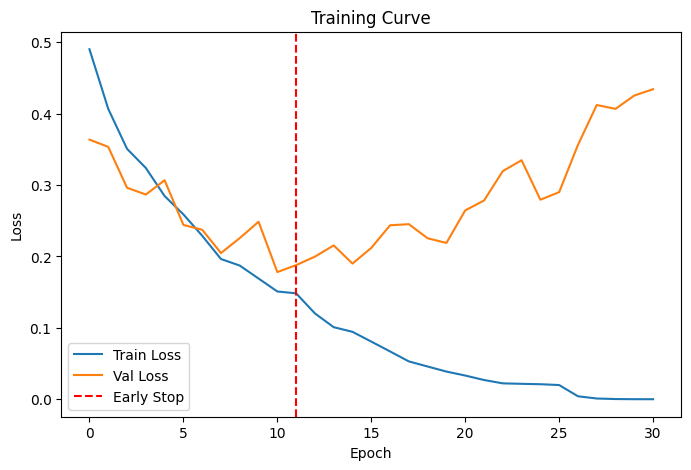

Model terbaik disimpan: dual_input_cnn_01.pth
Test Accuracy: 91.50%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import os

# ====== Dataset Class ======
class SpoofDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        rgb_image = Image.open(row['rgb']).convert('RGB')
        lbp_image = Image.open(row['lbp']).convert('L')  # LBP adalah grayscale
        label = torch.tensor(row['label'], dtype=torch.long)

        if self.transform:
            rgb_image = self.transform(rgb_image)
            lbp_image = self.transform(lbp_image)

        return rgb_image, lbp_image, label

# ====== Balanced Manual Split ======
metadata_df = pd.read_csv('/content/preprocessed/metadata_1.csv')

live_df = metadata_df[metadata_df['label'] == 0].reset_index(drop=True)
spoof_df = metadata_df[metadata_df['label'] == 1].reset_index(drop=True)

def balanced_split(df, train_ratio=0.8, val_ratio=0.1):
    total = len(df)
    train_end = int(train_ratio * total)
    val_end = int((train_ratio + val_ratio) * total)
    train = df.iloc[:train_end]
    val = df.iloc[train_end:val_end]
    test = df.iloc[val_end:]
    return train, val, test

live_train, live_val, live_test = balanced_split(live_df)
spoof_train, spoof_val, spoof_test = balanced_split(spoof_df)

train_df = pd.concat([live_train, spoof_train]).sample(frac=1, random_state=42).reset_index(drop=True)
val_df = pd.concat([live_val, spoof_val]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([live_test, spoof_test]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Train:", train_df['label'].value_counts().to_dict())
print("Val:", val_df['label'].value_counts().to_dict())
print("Test:", test_df['label'].value_counts().to_dict())

# ====== Transforms and DataLoaders ======
train_transform = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.ToTensor()
])

batch_size = 32
train_dataset = SpoofDataset(train_df, transform=train_transform)
val_dataset = SpoofDataset(val_df, transform=test_transform)
test_dataset = SpoofDataset(test_df, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ====== Training Function ======
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=200, patience=20):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience_counter = 0
    early_stopping_epoch = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for rgb_images, lbp_images, labels in train_loader:
            rgb_images, lbp_images, labels = rgb_images.to(device), lbp_images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(rgb_images, lbp_images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validasi
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for rgb_images, lbp_images, labels in val_loader:
                rgb_images, lbp_images, labels = rgb_images.to(device), lbp_images.to(device), labels.to(device)
                outputs = model(rgb_images, lbp_images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # Scheduler step
        scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            early_stopping_epoch = epoch + 1
            torch.save(model.state_dict(), 'dual_input_cnn_01.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Plot Loss
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stop')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Curve')
    plt.show()
    print(f"Model terbaik disimpan: dual_input_cnn_01.pth")

# ====== Inisialisasi Model dan Training ======
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DualInputCNN(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=200, patience=20)
evaluate_model(model, test_loader, device, load_model='dual_input_cnn_01.pth')

### Training ke-2

Train: {0: 4000, 1: 4000}
Val: {1: 500, 0: 500}
Test: {1: 500, 0: 500}
Epoch 1/200 - Train Loss: 0.5566 | Val Loss: 0.4587 | LR: 0.000100
Epoch 2/200 - Train Loss: 0.4792 | Val Loss: 0.4368 | LR: 0.000100
Epoch 3/200 - Train Loss: 0.4456 | Val Loss: 0.3765 | LR: 0.000100
Epoch 4/200 - Train Loss: 0.4265 | Val Loss: 0.3803 | LR: 0.000100
Epoch 5/200 - Train Loss: 0.4106 | Val Loss: 0.3919 | LR: 0.000100
Epoch 6/200 - Train Loss: 0.4004 | Val Loss: 0.3349 | LR: 0.000100
Epoch 7/200 - Train Loss: 0.3939 | Val Loss: 0.3341 | LR: 0.000100
Epoch 8/200 - Train Loss: 0.3711 | Val Loss: 0.3156 | LR: 0.000100
Epoch 9/200 - Train Loss: 0.3592 | Val Loss: 0.2991 | LR: 0.000100
Epoch 10/200 - Train Loss: 0.3516 | Val Loss: 0.2994 | LR: 0.000100
Epoch 11/200 - Train Loss: 0.3370 | Val Loss: 0.2746 | LR: 0.000100
Epoch 12/200 - Train Loss: 0.3310 | Val Loss: 0.2793 | LR: 0.000100
Epoch 13/200 - Train Loss: 0.3157 | Val Loss: 0.3013 | LR: 0.000100
Epoch 14/200 - Train Loss: 0.3113 | Val Loss: 0.2645 |

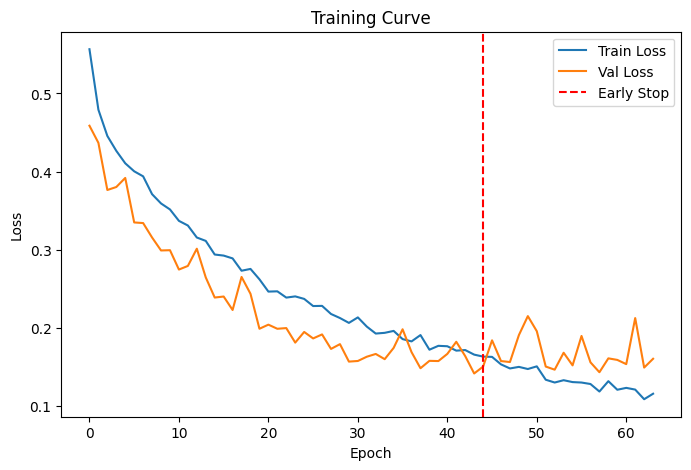

Model terbaik disimpan: dual_input_cnn_01.pth
Test Accuracy: 93.20%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import os

# ====== Dataset Class ======
class SpoofDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        rgb_image = Image.open(row['rgb']).convert('RGB')
        lbp_image = Image.open(row['lbp']).convert('L')  # LBP adalah grayscale
        label = torch.tensor(row['label'], dtype=torch.long)

        if self.transform:
            rgb_image = self.transform(rgb_image)
            lbp_image = self.transform(lbp_image)

        return rgb_image, lbp_image, label

# ====== Balanced Manual Split ======
metadata_df = pd.read_csv('/content/preprocessed/metadata_1.csv')

live_df = metadata_df[metadata_df['label'] == 0].reset_index(drop=True)
spoof_df = metadata_df[metadata_df['label'] == 1].reset_index(drop=True)

def balanced_split(df, train_ratio=0.8, val_ratio=0.1):
    total = len(df)
    train_end = int(train_ratio * total)
    val_end = int((train_ratio + val_ratio) * total)
    train = df.iloc[:train_end]
    val = df.iloc[train_end:val_end]
    test = df.iloc[val_end:]
    return train, val, test

live_train, live_val, live_test = balanced_split(live_df)
spoof_train, spoof_val, spoof_test = balanced_split(spoof_df)

train_df = pd.concat([live_train, spoof_train]).sample(frac=1, random_state=42).reset_index(drop=True)
val_df = pd.concat([live_val, spoof_val]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([live_test, spoof_test]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Train:", train_df['label'].value_counts().to_dict())
print("Val:", val_df['label'].value_counts().to_dict())
print("Test:", test_df['label'].value_counts().to_dict())

# ====== Transforms and DataLoaders ======
# ====== Transforms and DataLoaders ======
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(size=(240, 240), scale=(0.8, 1.0)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.ToTensor()
])

batch_size = 64
train_dataset = SpoofDataset(train_df, transform=train_transform)
val_dataset = SpoofDataset(val_df, transform=test_transform)
test_dataset = SpoofDataset(test_df, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ====== Training Function ======
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=200, patience=20):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience_counter = 0
    early_stopping_epoch = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for rgb_images, lbp_images, labels in train_loader:
            rgb_images, lbp_images, labels = rgb_images.to(device), lbp_images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(rgb_images, lbp_images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validasi
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for rgb_images, lbp_images, labels in val_loader:
                rgb_images, lbp_images, labels = rgb_images.to(device), lbp_images.to(device), labels.to(device)
                outputs = model(rgb_images, lbp_images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # Scheduler step
        scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            early_stopping_epoch = epoch + 1
            torch.save(model.state_dict(), 'dual_input_cnn_01.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Plot Loss
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stop')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Curve')
    plt.show()
    print(f"Model terbaik disimpan: dual_input_cnn_01.pth")

# ====== Inisialisasi Model dan Training ======
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DualInputCNN(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=200, patience=20)
evaluate_model(model, test_loader, device, load_model='dual_input_cnn_01.pth')

## Train dengan dataset primer

Epoch 1/100 - Train Loss: 1.4775 | Val Loss: 0.5840
Epoch 2/100 - Train Loss: 0.7625 | Val Loss: 0.3142
Epoch 3/100 - Train Loss: 0.3716 | Val Loss: 0.1927
Epoch 4/100 - Train Loss: 0.2483 | Val Loss: 0.1169
Epoch 5/100 - Train Loss: 0.1411 | Val Loss: 0.0750
Epoch 6/100 - Train Loss: 0.1011 | Val Loss: 0.0535
Epoch 7/100 - Train Loss: 0.0772 | Val Loss: 0.0400
Epoch 8/100 - Train Loss: 0.0679 | Val Loss: 0.0309
Epoch 9/100 - Train Loss: 0.0609 | Val Loss: 0.0253
Epoch 10/100 - Train Loss: 0.0542 | Val Loss: 0.0219
Epoch 11/100 - Train Loss: 0.0453 | Val Loss: 0.0180
Epoch 12/100 - Train Loss: 0.0336 | Val Loss: 0.0152
Epoch 13/100 - Train Loss: 0.0316 | Val Loss: 0.0134
Epoch 14/100 - Train Loss: 0.0286 | Val Loss: 0.0118
Epoch 15/100 - Train Loss: 0.0202 | Val Loss: 0.0106
Epoch 16/100 - Train Loss: 0.0184 | Val Loss: 0.0093
Epoch 17/100 - Train Loss: 0.0242 | Val Loss: 0.0083
Epoch 18/100 - Train Loss: 0.0199 | Val Loss: 0.0073
Epoch 19/100 - Train Loss: 0.0144 | Val Loss: 0.0065
Ep

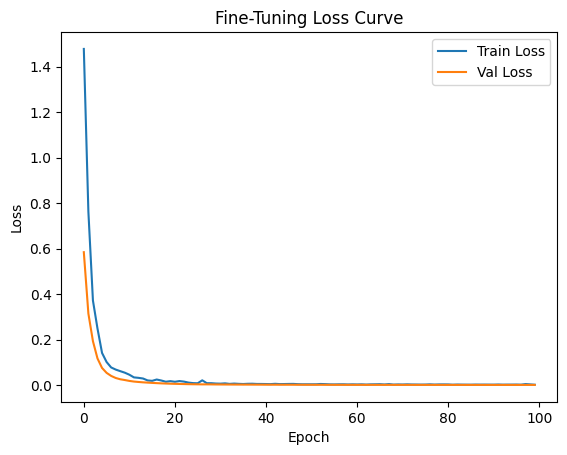

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import os

# === Dataset Kustom ===
class SpoofDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        rgb_image = Image.open(row['rgb']).convert('RGB')
        lbp_image = Image.open(row['lbp']).convert('L')
        label = torch.tensor(row['label'], dtype=torch.long)

        if self.transform:
            rgb_image = self.transform(rgb_image)
            lbp_image = self.transform(lbp_image)

        return rgb_image, lbp_image, label

# === Transformasi Gambar ===
transform = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.ToTensor()
])

# === Dataset dan Dataloader ===
batch_size = 16

train_dataset = SpoofDataset(train_df, transform=transform)
val_dataset = SpoofDataset(val_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# === Inisialisasi Model ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DualInputCNN(num_classes=2).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/dual_input_cnn_01.pth"))

# === Optimizer & Scheduler ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

# === Fungsi Training ===
def train_finetune(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=100):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for rgb, lbp, labels in train_loader:
            rgb, lbp, labels = rgb.to(device), lbp.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(rgb, lbp)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for rgb, lbp, labels in val_loader:
                rgb, lbp, labels = rgb.to(device), lbp.to(device), labels.to(device)
                outputs = model(rgb, lbp)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "/content/drive/MyDrive/dual_input_cnn_finetuned.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Plot
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.title("Fine-Tuning Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

# === Jalankan Fine-Tuning ===
train_finetune(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=100)

In [ ]:
evaluate_model(model, test_loader, device, load_model='/content/drive/MyDrive/dual_input_cnn_finetuned.pth')

Test Accuracy: 77.80%


# Testing dengan data real condition dari Webcam

In [ ]:
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from skimage.feature import local_binary_pattern
from facenet_pytorch import MTCNN

# Inisialisasi MTCNN
mtcnn = MTCNN()

# Fungsi untuk ekstraksi LBP
def get_lbp(image, radius=1, n_points=8):
    if len(image.shape) > 2 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image

    lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
    return lbp

# Fungsi untuk resize dengan padding agar aspect ratio tetap terjaga
def resize_with_padding(image, target_size=(240, 240)):
    old_size = image.size
    ratio = min(target_size[0] / old_size[0], target_size[1] / old_size[1])
    new_size = (int(old_size[0] * ratio), int(old_size[1] * ratio))

    resized_image = image.resize(new_size, Image.LANCZOS)
    new_image = Image.new("RGB", target_size, (0, 0, 0))
    new_image.paste(resized_image, ((target_size[0] - new_size[0]) // 2,
                                    (target_size[1] - new_size[1]) // 2))
    return new_image

# Fungsi untuk memproses gambar input dan hanya ambil 1 wajah
def process_input_image(image_path):
    data = []

    # Baca gambar
    image = Image.open(image_path).convert('RGB')

    # Deteksi wajah
    faces, _ = mtcnn.detect(image)
    if faces is not None and len(faces) > 0:
        print(f'Found {len(faces)} face(s) in the image')

        # Pilih wajah terbesar berdasarkan luas bbox (x2-x1)*(y2-y1)
        largest_face = max(faces, key=lambda box: (box[2] - box[0]) * (box[3] - box[1]))
        x1, y1, x2, y2 = [int(coord) for coord in largest_face]

        face = image.crop((x1, y1, x2, y2))
        if face.size != (0, 0):
            face = resize_with_padding(face, (240, 240))

            # Ekstraksi LBP
            face_np = np.array(face)
            lbp = get_lbp(face_np)

            if lbp is None:
                print("LBP extraction failed. Skipping this image.")
                return pd.DataFrame()  # Return empty DataFrame

            data.append({
                'RGB': face,
                'LBP': Image.fromarray(lbp.astype(np.uint8)),
                'label': 'unknown'
            })
    else:
        print('No faces found in the image.')

    return pd.DataFrame(data)

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from PIL import Image
import numpy as np

# Wrapper untuk pakai GradCAM hanya di input RGB
class RGBOnlyModel(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        lbp_dummy = torch.zeros(x.size(0), 1, x.size(2), x.size(3)).to(x.device)
        return self.model(x, lbp_dummy)

# Grad-CAM test dari dataset hasil crop wajah
def test_model_with_gradcam(model, dataset, device):
    model.eval()
    transform = transforms.Compose([transforms.ToTensor()])

    wrapped_model = RGBOnlyModel(model)  # Bungkus model biar bisa dipakai Grad-CAM
    target_layer = wrapped_model.model.conv5  # Layer yang akan diinspeksi

    for i, row in dataset.iterrows():
        rgb_img = row['RGB']
        lbp_img = row['LBP']

        # Transform ke tensor
        rgb_tensor = transform(rgb_img).unsqueeze(0).to(device)
        lbp_tensor = transform(lbp_img).unsqueeze(0).to(device)

        # Pastikan input RGB perlu gradien (agar Grad-CAM bisa backward)
        rgb_tensor.requires_grad = True

        # Forward pass untuk prediksi
        outputs = model(rgb_tensor, lbp_tensor)
        _, predicted = torch.max(outputs, 1)
        label = 'Real' if predicted.item() == 0 else 'Fake'

        # Grad-CAM (hanya pada RGB channel)
        with GradCAM(model=wrapped_model, target_layers=[target_layer]) as cam:
            targets = [ClassifierOutputTarget(predicted.item())]
            grayscale_cam = cam(input_tensor=rgb_tensor, targets=targets)[0]

        # Visualisasi
        input_image = rgb_tensor.squeeze().detach().cpu().permute(1, 2, 0).numpy()
        input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())
        cam_image = show_cam_on_image(input_image, grayscale_cam, use_rgb=True)

        # Tampilkan hasil
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(row['RGB'])
        axes[0].set_title(f"RGB Image - Pred: {label}")
        axes[0].axis('off')

        axes[1].imshow(cam_image)
        axes[1].set_title("Grad-CAM (RGB Only)")
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

        if i >= 4:
            break

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DualInputCNN(num_classes=2).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/dual_input_cnn_finetuned.pth', map_location=device))
model.eval()

DualInputCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout_conv1): Dropout(p=0.2, inplace=False)
  (conv1_lbp): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_lbp): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_lbp): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout_conv2): Dropout(p=0.2, inplace=False)
  (conv4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout_conv3): Dropout(p=0.2, inplace=False)
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(7, 7))
  (fc1): Linear(in_features=25088, out_features=512, bias=Tru

Found 1 face(s) in the image


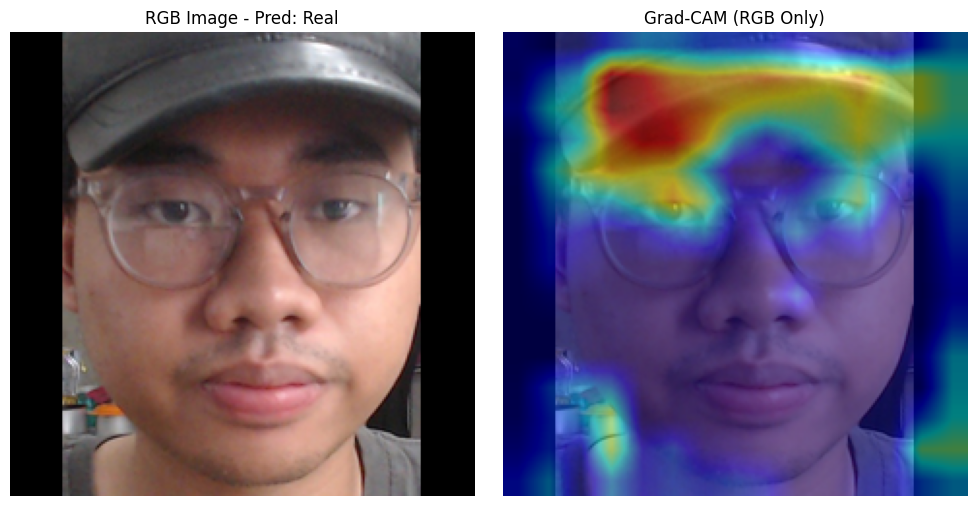

In [ ]:
# Testing
dataset_1 = process_input_image('/content/drive/MyDrive/Test_1.jpg')
# Jalankan evaluasi + Grad-CAM
test_model_with_gradcam(model, dataset_1, device)

Found 1 face(s) in the image


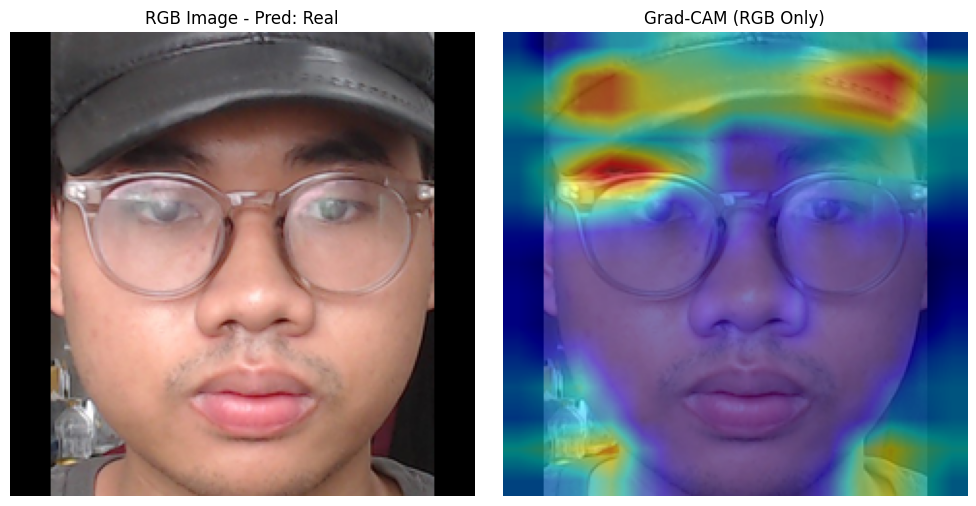

In [ ]:
dataset_2 = process_input_image('/content/drive/MyDrive/Test_2.jpg')
test_model_with_gradcam(model, dataset_2, device)

Found 1 face(s) in the image


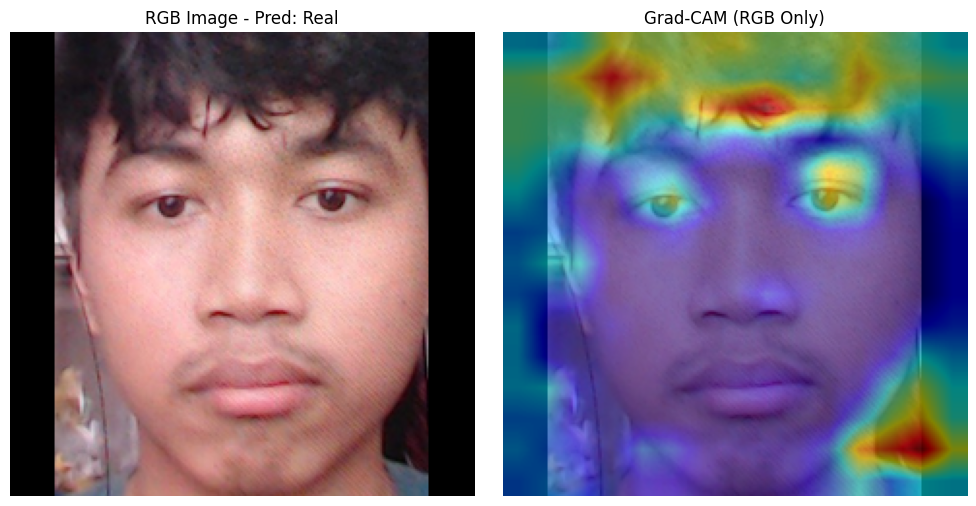

In [ ]:
dataset_3 = process_input_image('/content/drive/MyDrive/Test_A1.jpg')
test_model_with_gradcam(model, dataset_3, device)

Found 2 face(s) in the image


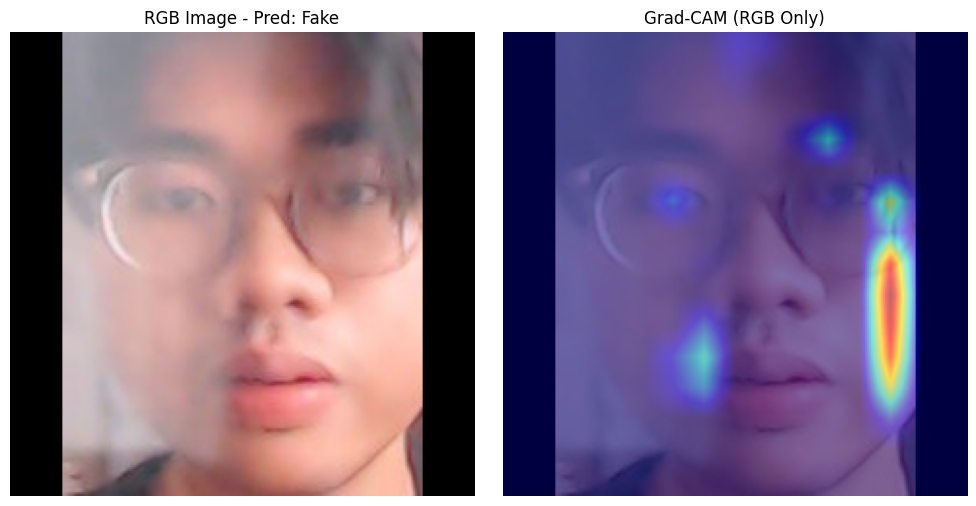

In [ ]:
# Contoh penggunaan
dataset_4 = process_input_image('/content/drive/MyDrive/Test_4.jpg')
test_model_with_gradcam(model, dataset_4, device)

Found 1 face(s) in the image


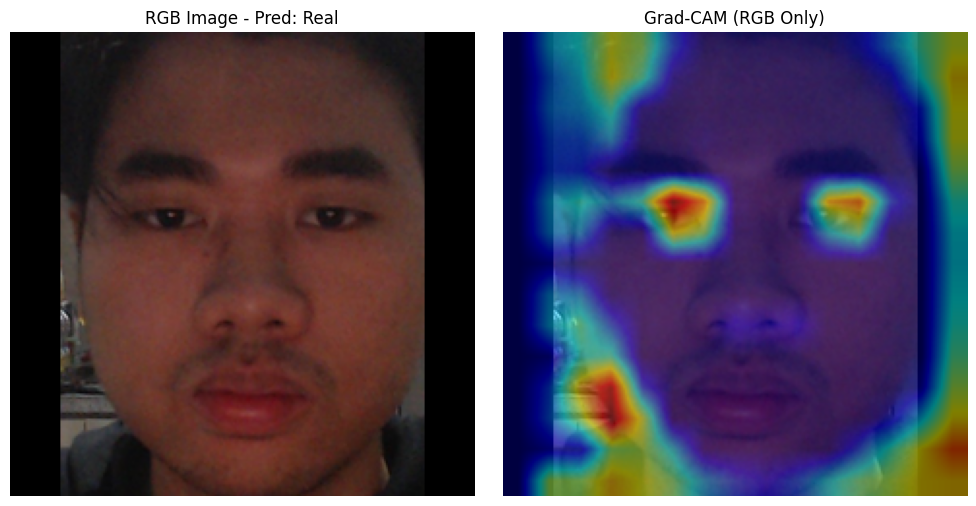

In [ ]:
# Contoh penggunaan
dataset_5 = process_input_image('/content/drive/MyDrive/Test_B.jpg')
test_model_with_gradcam(model, dataset_5, device)

Found 1 face(s) in the image


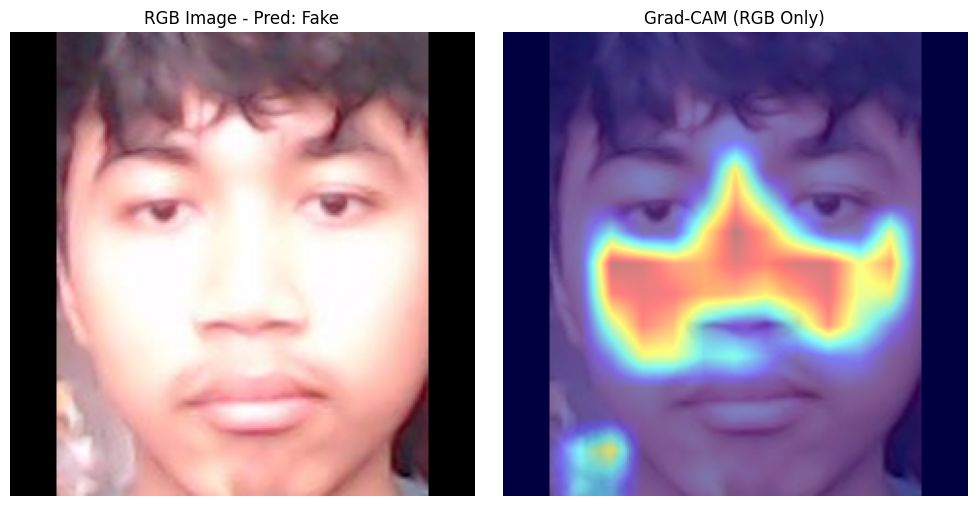

In [ ]:
dataset_6 = process_input_image('/content/drive/MyDrive/Test_A2.jpg')
test_model_with_gradcam(model, dataset_6, device)